In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
%matplotlib inline 
import matplotlib.pyplot as plt
import os
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [2]:
from keras import layers
from keras.models import Model
from keras.models import load_model
from keras import callbacks
import os
import cv2
import string
import numpy as np

#Init main values
symbols = string.ascii_uppercase + "0123456789" # All symbols captcha can contain
num_symbols = len(symbols)
img_shape = (35, 110, 1)
PATH = "./own_captcha/"

In [3]:
print(num_symbols)

36


In [4]:
def create_model():
    img = layers.Input(shape=img_shape) # Get image as an input and process it through some Convs
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 100x25
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
    conv3 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 25x7
    
    # Get flattened vector and make 5 branches from it. Each branch will predict one letter
    flat = layers.Flatten()(mp3)
    outs = []
    for _ in range(4):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_symbols, activation='sigmoid')(drop)

        outs.append(res)
    
    # Compile model and return it
    model = Model(img, outs)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

In [5]:
def preprocess_data():
    n_samples = len(os.listdir(PATH))
    X = np.zeros((n_samples, 35, 110, 1)) #1070*50*200
    y = np.zeros((4, n_samples, num_symbols)) #5*1070*36

    for i, pic in enumerate(os.listdir(PATH)):
        # Read image as grayscale
        img = cv2.imread(os.path.join(PATH, pic), cv2.IMREAD_GRAYSCALE)
        thresh_img1 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
        img = cv2.morphologyEx(thresh_img1, cv2.MORPH_CLOSE, np.ones((2,2), np.uint8))
        pic_target = pic[:-4]
        if len(pic_target) < 6:
            img = img / 255.0 #img.shape = (35, 110)
            img = np.reshape(img, (35, 110, 1))
            # Define targets and code them using OneHotEncoding
            targs = np.zeros((4, num_symbols))
            for j, l in enumerate(pic_target):
                ind = symbols.find(l)
                print(j, ind, pic_target)
                targs[j, ind] = 1
            X[i] = img
            y[:, i] = targs

    
    # Return final data
    return X, y

X, y = preprocess_data()
total = len(X)
size_test = int(len(X)*0.01)
X_train, y_train = X[:total-size_test], y[:, :total-size_test]
X_test, y_test = X[total-size_test:], y[:, total-size_test:]

0 26 0003
1 26 0003
2 26 0003
3 29 0003
0 26 0079
1 26 0079
2 33 0079
3 35 0079
0 26 007A
1 26 007A
2 33 007A
3 0 007A
0 26 007R
1 26 007R
2 33 007R
3 17 007R
0 26 007Y
1 26 007Y
2 33 007Y
3 24 007Y
0 26 00BA
1 26 00BA
2 1 00BA
3 0 00BA
0 26 00IJ
1 26 00IJ
2 8 00IJ
3 9 00IJ
0 26 00OJ
1 26 00OJ
2 14 00OJ
3 9 00OJ
0 26 0143
1 27 0143
2 30 0143
3 29 0143
0 26 01A0
1 27 01A0
2 0 01A0
3 26 01A0
0 26 01B9
1 27 01B9
2 1 01B9
3 35 01B9
0 26 01D6
1 27 01D6
2 3 01D6
3 32 01D6
0 26 01JX
1 27 01JX
2 9 01JX
3 23 01JX
0 26 01Q9
1 27 01Q9
2 16 01Q9
3 35 01Q9
0 26 01T3
1 27 01T3
2 19 01T3
3 29 01T3
0 26 01WH
1 27 01WH
2 22 01WH
3 7 01WH
0 26 01Z8
1 27 01Z8
2 25 01Z8
3 34 01Z8
0 26 020M
1 28 020M
2 26 020M
3 12 020M
0 26 023B
1 28 023B
2 29 023B
3 1 023B
0 26 023E
1 28 023E
2 29 023E
3 4 023E
0 26 0271
1 28 0271
2 33 0271
3 27 0271
0 26 02A7
1 28 02A7
2 0 02A7
3 33 02A7
0 26 02JV
1 28 02JV
2 9 02JV
3 21 02JV
0 26 02LI
1 28 02LI
2 11 02LI
3 8 02LI
0 26 02M4
1 28 02M4
2 12 02M4
3 30 02M4
0 26 02P2
1 28 0

In [6]:
print(len(X_train), len(X_test), (len(X_train)+ len(X_test))==total, total)

6525 65 True 6590


In [7]:
model=create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 35, 110, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 35, 110, 16)  160         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 18, 55, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 18, 55, 32)   4640        ['max_pooling2d[0][0]']      

In [10]:
#model = create_model()
hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3]], batch_size=128, epochs=100,verbose=1, validation_split=0.1)

Epoch 1/100
46/46 [==============================] - 2s 35ms/step - loss: 0.1888 - dense_1_loss: 0.0487 - dense_3_loss: 0.0466 - dense_5_loss: 0.0444 - dense_7_loss: 0.0491 - dense_1_accuracy: 0.9796 - dense_3_accuracy: 0.9825 - dense_5_accuracy: 0.9854 - dense_7_accuracy: 0.9837 - val_loss: 45.1137 - val_dense_1_loss: 44.7911 - val_dense_3_loss: 0.1712 - val_dense_5_loss: 0.0621 - val_dense_7_loss: 0.0894 - val_dense_1_accuracy: 0.1317 - val_dense_3_accuracy: 0.9709 - val_dense_5_accuracy: 0.9847 - val_dense_7_accuracy: 0.9724
Epoch 2/100
46/46 [==============================] - 1s 32ms/step - loss: 0.1469 - dense_1_loss: 0.0378 - dense_3_loss: 0.0364 - dense_5_loss: 0.0394 - dense_7_loss: 0.0334 - dense_1_accuracy: 0.9879 - dense_3_accuracy: 0.9886 - dense_5_accuracy: 0.9859 - dense_7_accuracy: 0.9891 - val_loss: 47.7945 - val_dense_1_loss: 47.4609 - val_dense_3_loss: 0.1629 - val_dense_5_loss: 0.0776 - val_dense_7_loss: 0.0932 - val_dense_1_accuracy: 0.1348 - val_dense_3_accuracy: 0

In [11]:
# Define function to predict captcha
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    thresh_img1 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
    img = cv2.morphologyEx(thresh_img1, cv2.MORPH_CLOSE, np.ones((2,2), np.uint8))
    if img is not None:
        img = img / 255.0
    else:
        print("Not detected")
    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (4, 36))
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt#, sum(probs) / 5



In [12]:
score= model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3]],verbose=1)
print('Test Loss and accuracy:', score)

3/3 [==============================] - 0s 45ms/step - loss: 74.1501 - dense_1_loss: 73.6055 - dense_3_loss: 0.0786 - dense_5_loss: 3.4340e-04 - dense_7_loss: 0.4656 - dense_1_accuracy: 0.0000e+00 - dense_3_accuracy: 0.9846 - dense_5_accuracy: 1.0000 - dense_7_accuracy: 0.9692
Test Loss and accuracy: [74.15006256103516, 73.60552978515625, 0.07857402414083481, 0.0003434041573200375, 0.46561360359191895, 0.0, 0.9846153855323792, 1.0, 0.9692307710647583]


In [13]:
model.save_weights("own_captcha_best_denoise_DENSEX128.h5")
model.save("model_own_captcha_denoise_DENSEX128.h5")

In [14]:
# Check model on some samples
model.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3]])
print(predict('./own_captcha/0003.png'))

1/1 [==============================] - 0s 256ms/step
0003


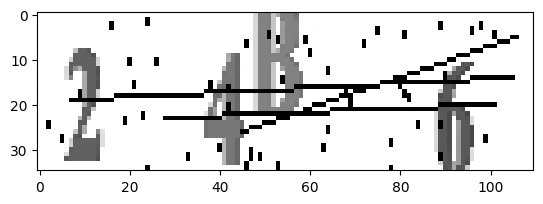

In [15]:
#Lets test an unknown captcha
#preview
%matplotlib inline 
import matplotlib.pyplot as plt
img=cv2.imread('./captcha_datasets/image - 2023-02-14T092408.563.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [16]:
#Lets Predict By Model
print("Predicted Captcha =",predict('./captcha_datasets/image - 2023-02-14T092408.563.jpg'))

1/1 [==============================] - 0s 15ms/step
Predicted Captcha = 24E6


In [17]:
model = load_model("model_own_captcha_denoise_DENSEX128.h5")

In [37]:
def predict_(path="./captcha_datasets/", limit=10):
    total = 0
    truth = 0
    for i,img_ in enumerate(os.listdir(path)):
        if i >= limit:
            break
        img_path = os.path.join(path, img_)
        # img=cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
        # plt.imshow(img, cmap=plt.get_cmap('gray'))
        # plt.show()
        pre = predict(img_path)
        print(f"Truth: {img_[:-4]}, Predicted Captcha: {pre}")
        total += 1
        truth += 1 if img_[:-4] == pre else 0
        if img_[:-4] != pre:
            print(img_[:-4], pre)
        if limit is None:
            continue
        if os.path.exists(f"./captcha_datasets/{pre}.png") or os.path.exists(f"./captcha_datasets/{pre}.jpg"):
            continue
        os.rename(img_path, os.path.join(path, f"{pre}.png"))
        print(f"{img_path}, {pre} rename")
    return total, truth, truth/total if total !=0 else 0
total, truth, accuracy = predict_(limit=2)

1/1 [==============================] - 0s 19ms/step
Truth: image - 2023-02-14T092343.279, Predicted Captcha: 0G52
image - 2023-02-14T092343.279 0G52
./captcha_datasets/image - 2023-02-14T092343.279.jpg, 0G52 rename
1/1 [==============================] - 0s 18ms/step
Truth: image - 2023-02-14T092343.801, Predicted Captcha: 24X8
image - 2023-02-14T092343.801 24X8
./captcha_datasets/image - 2023-02-14T092343.801.jpg, 24X8 rename


In [33]:
total, truth, total-truth, accuracy

(0, 0, 0, 0)

In [26]:
#testing
#c=0
#for i, pic in enumerate(os.listdir('../input/captcha-version-2-images/samples/samples')):
        # Read image as grayscale
        
        #if i>970:    

            #img = cv2.imread(os.path.join('../input/captcha-version-2-images/samples/samples', pic), cv2.IMREAD_GRAYSCALE)
            #print("Predicted Captcha =",predict(os.path.join('../input/captcha-version-2-images/samples/samples',pic)))
            #plt.imshow(img, cmap=plt.get_cmap('gray'))
            #pr=predict(os.path.join('../input/captcha-version-2-images/samples/samples',pic))
            #pic_target = pic[:-4]
            #if pr==pic_target:
                #c=c+1
                #print(c)
            #print(pic_target)
#print((c/100)*100)